<a href="https://colab.research.google.com/github/sinheechan/CAM_Binary-classifier/blob/main/Find_a_Car_Park_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find_a_car_park_CAM(Class Activation Map)



## 1. Setting

In [ ]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

## 2. Data Introduce

본 과정에서 데이터로 Kaggle의 Find a Car Park 데이터셋을 활용합니다.

해당 데이터셋은 지역의 특정 지리적 공간 반경 내에 있는 경우 여유 공간이 있는지 여부를 식별하고

사용자에게 메시지를 보내는 데 사용되는 주차장 공간의 이미지 파일이 내장되어 있습니다.

이미지는 무료 또는 전체로 분류됩니다. 이미지 해상도는 각각 1296 x 972픽셀입니다.

이를 통해 주차장 내 주차공간의 유무를 판단하는 모델을 구현합니다.

In [ ]:
# Kaggle : username / key
os.environ['KAGGLE_USERNAME'] = 'sinheechan'
os.environ['KAGGLE_KEY'] = 'd8cd8b54b5de471688c0790be19a045c'

!kaggle datasets download -d daggysheep/find-a-car-park

100% 5.00G/5.00G [04:45<00:00, 20.9MB/s]
100% 5.00G/5.00G [04:45<00:00, 18.8MB/s]


In [ ]:
!unzip -q find-a-car-park.zip

## 3. EDA

2195
1067


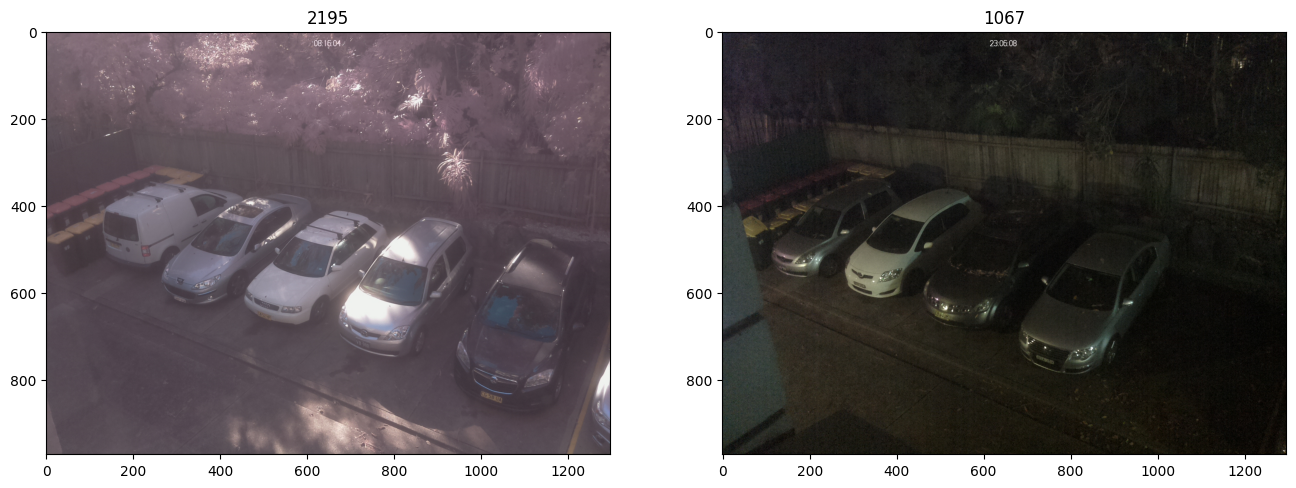

In [ ]:
# Preview Dataset
BASE_PATH = 'data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))
print(len(full_list))
print(len(free_list))

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))

# Full image
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)

# Free image
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

## 4. Data Engineering

ImageDataGenerator 객체를 설정합니다.

주어진 이미지를 모델에 제공하기 전에 Train / Val 각 데이터셋 별 데이터를 증강하고 전처리하는 작업을 진행합니다.

In [ ]:
# Train Dataset
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

# Val Dataset
val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

디렉토리에서 이미지를 로드하고, 데이터를 배치 단위로 생성하여 신경망 모델에 제공하는데 사용되는 제너레이터(Generator)를 설정합니다.

In [ ]:
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


## 5. Model

MobileNetV2 모델을 기본 네트워크로 사용하여 새로운 분류기를 추가하는 작업을 수행합니다.

MobileNetV2는 작고 경량화된 딥러닝 모델로, 모바일 및 임베디드 기기에서 컴퓨터 비전 작업을 수행하기 위한 검증된 모델입니다.

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원 벡터로 변환
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개로 나누는 분류기

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) # Model Compile

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

사전 훈련된 모델의 일부 레이어만 학습 가능하도록 설정합니다.

In [ ]:
for layer in model.layers:
    layer.trainable = True

## 6. Test

fit_generator 함수를 사용하여 모델을 훈련시키고, 훈련 과정 중에 검증 데이터를 사용하여 모델의 성능을 평가합니다.

In [ ]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('btmodel.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

<ipython-input-9-7ccdefafb41a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.1521 - acc: 0.9544
Epoch 1: val_acc improved from -inf to 0.59077, saving model to btmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 159s 1s/step - loss: 0.1521 - acc: 0.9544 - val_loss: 10.7965 - val_acc: 0.5908
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.0383 - acc: 0.9898
Epoch 2: val_acc did not improve from 0.59077
92/92 [==============================] - 101s 1s/step - loss: 0.0383 - acc: 0.9898 - val_loss: 8.2254 - val_acc: 0.3415
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.0491 - acc: 0.9864
Epoch 3: val_acc did not improve from 0.59077
92/92 [==============================] - 98s 1s/step - loss: 0.0491 - acc: 0.9864 - val_loss: 14.8624 - val_acc: 0.3262
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.0237 - acc: 0.9939
Epoch 4: val_acc did not improve from 0.59077
92/92 [==============================] - 97s 1s/step - loss: 0.0237 - acc: 0.9939 - val_loss: 10.4003 - val_acc: 0.3262
Epoch 5/10
92/92 [==============================] - ETA: 0s - loss: 0.0160 - acc: 0.9966
Epoch 5: val_acc did not 

모델 훈련 과정 중에 발생한 손실(loss)과 정확도(accuracy)를 시각화하여 훈련 및 검증 성능을 평가합니다.

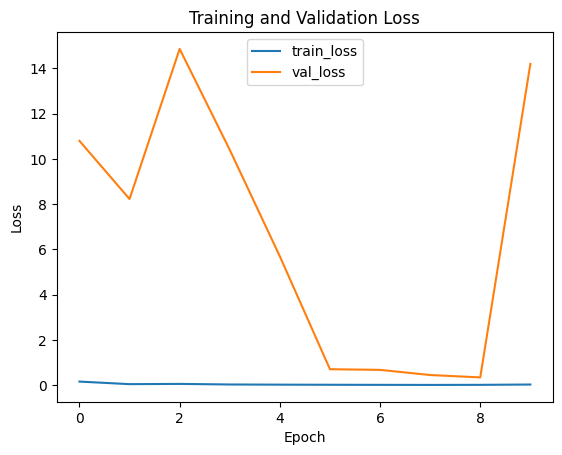

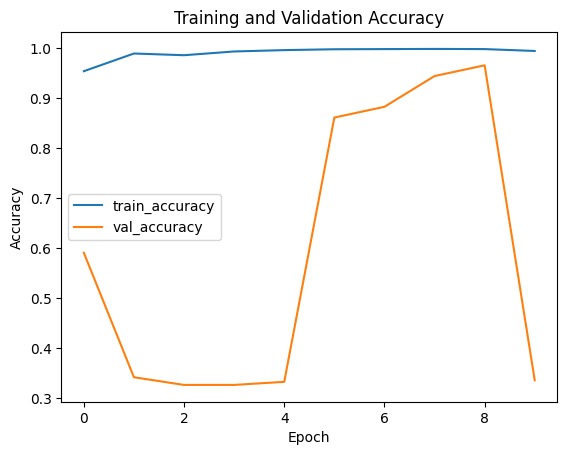

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

이전에 저장된 모델 'btmodel.h5'마지막 레이어의 가중치를 가져와 새로운 모델을 생성합니다.

새로운 모델은 기존 모델에서 일부 층을 가져와서 새롭게 구성됩니다.



In [ ]:
model = load_model('btmodel.h5')

last_weight = model.layers[-1].get_weights()[0]

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # layer : before GAP
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

이미지를 모델에 입력하여 예측을 수행하고, 해당 예측 결과를 시각화합니다.

1/1 [==============================] - 1s 1s/step


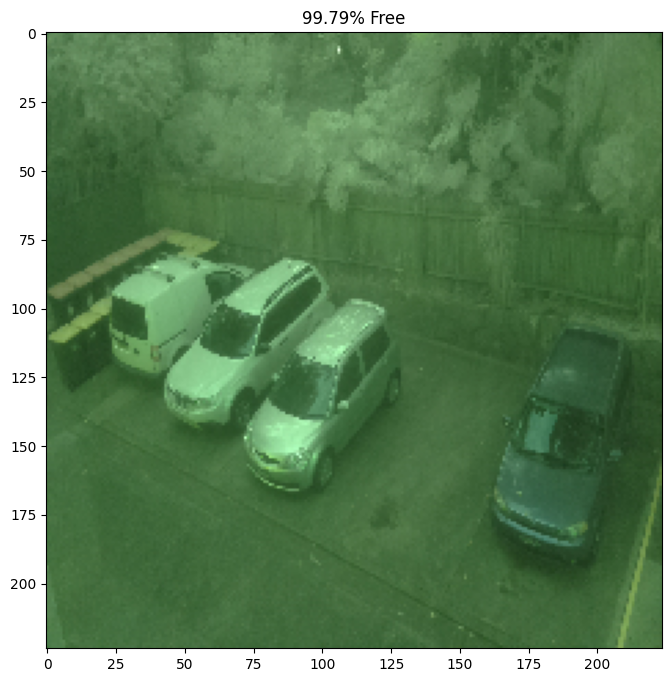

In [ ]:
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

모델이 입력 이미지의 어떤 중요한 부분을 인식하였는지 확인하기 위해 Activation Map을 그립니다.

1/1 [==============================] - 0s 24ms/step


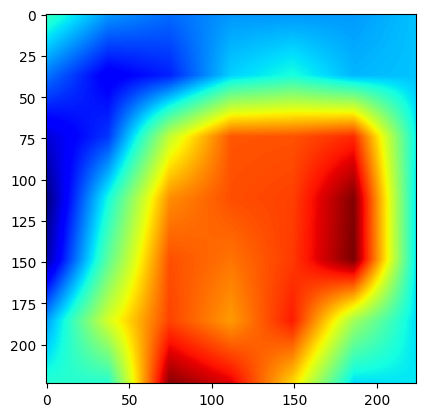

In [ ]:
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) GAP 전
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1) # GAP 생략

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

원본image 와 Activation Map 을 대조하여 성능을 검증합니다.

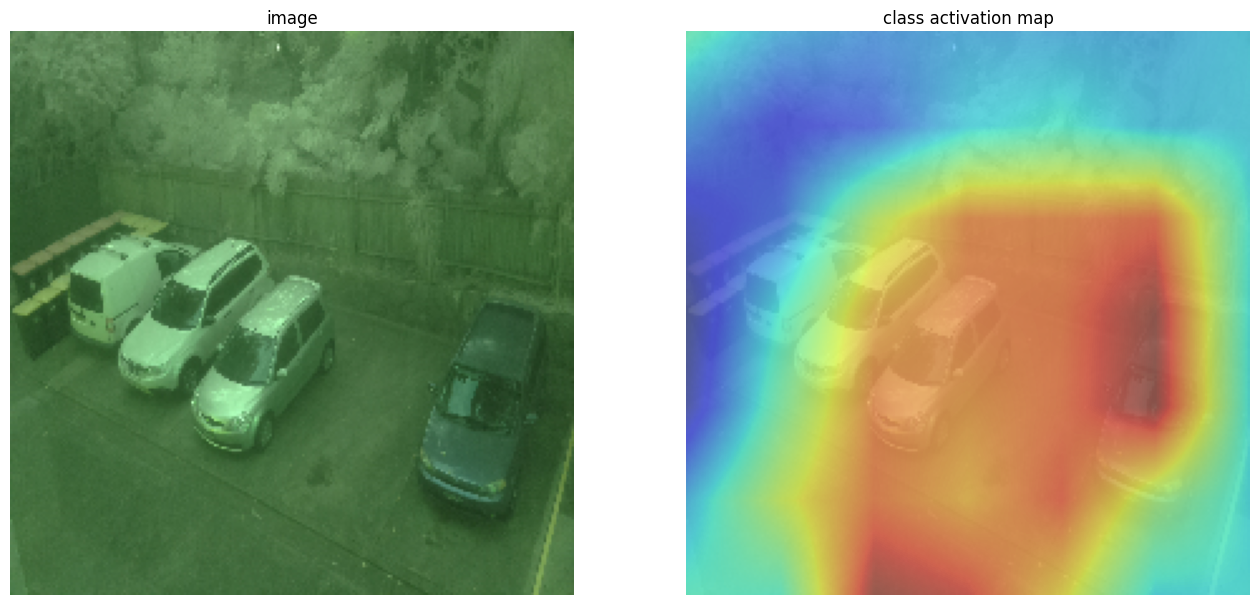

In [ ]:
# result
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

# input_image
ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

# Activation Map + input_image
ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()